# Problema del camino más corto

## Importamos las librerías

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

## Definimos los datos del problema

In [5]:
grafo = [
    ("Casa", "Lib1", 3),
    ("Casa", "Lib2", 6),
    ("Casa", "Lib3", 5),
    ("Lib1", "Caf1", 4),
    ("Lib1", "Caf2", 8),
    ("Lib2", "Caf1", 5),
    ("Lib2", "Caf2", 6),
    ("Lib2", "Caf3", 3),
    ("Lib3", "Caf3", 3),
    ("Caf1", "Univ", 7),
    ("Caf2", "Univ", 5),
    ("Caf3", "Univ", 3)
]

In [6]:
pos = {
    'Casa': (-0.5, 1),
    'Lib1': (1, 2),
    'Lib2': (0.5, 1),
    'Lib3': (1, 0),
    'Caf1': (2, 2),
    'Caf2': (2.5, 1),
    'Caf3': (2, 0),
    'Univ': (3.5, 1)
}

In [7]:
G = nx.DiGraph()
for origen, destino, costo in grafo:
    G.add_edge(origen, destino, weight=costo)

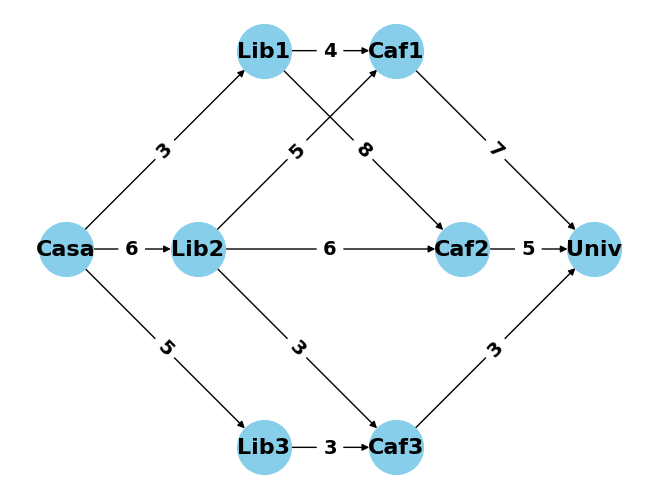

In [8]:
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=16, font_weight='bold', arrows=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=14, font_weight='bold')

plt.show()

## Definimos el Solver

In [9]:
solver = pywraplp.Solver.CreateSolver('CBC')

## Variables de decisión

\begin{align*}
x_{ij} =
\begin{cases}
1, & \text{si se toma el camino entre el nodo } i \text{ y el nodo } j \\
0, & \text{en caso contrario}
\end{cases}
\end{align*}

In [10]:
x = {}
for origen, destino, costo in grafo:
    x[origen, destino] = solver.BoolVar(f"x_({origen},{destino})")

## Función objetivo

\begin{align*}
\text{Minimizar } \quad & Z = 3 \cdot x_{\text{Casa,Lib1}} + 6 \cdot x_{\text{Casa,Lib2}} + 5 \cdot x_{\text{Casa,Lib3}} + 4 \cdot x_{\text{Lib1,Caf1}} + 8 \cdot x_{\text{Lib1,Caf2}} + 5 \cdot x_{\text{Lib2,Caf1}} \\
& + 6 \cdot x_{\text{Lib2,Caf2}} + 3 \cdot x_{\text{Lib2,Caf3}} + 3 \cdot x_{\text{Lib3,Caf3}} + 7 \cdot x_{\text{Caf1,Univ}} + 5 \cdot x_{\text{Caf2,Univ}} + 3 \cdot x_{\text{Caf3,Univ}}
\end{align*}

In [11]:
solver.Minimize(solver.Sum([costo * x[origen, destino] for origen, destino, costo in grafo]))

## Restricciones

**Restricciones de Flujo**

1\. Sólo puede salir una ruta desde Casa:

\begin{align*}
x_{\text{Casa,Lib1}} + x_{\text{Casa,Lib2}} + x_{\text{Casa,Lib3}} = 1
\end{align*}

2\. Sólo puede salir una ruta desde cualquier librería:

\begin{align*}
x_{\text{Lib1,Caf1}} + x_{\text{Lib1,Caf2}} = x_{\text{Casa,Lib1}}
\end{align*}

\begin{align*}
x_{\text{Lib2,Caf1}} + x_{\text{Lib2,Caf2}} + x_{\text{Lib2,Caf3}} = x_{\text{Casa,Lib2}}
\end{align*}

\begin{align*}
x_{\text{Lib3,Caf3}} = x_{\text{Casa,Lib3}}
\end{align*}

3\. Solo puede salir una ruta desde cualquier cafetería:

\begin{align*}
x_{\text{Caf1,Univ}} = x_{\text{Lib1,Caf1}} + x_{\text{Lib2,Caf1}}
\end{align*}

\begin{align*}
x_{\text{Caf2,Univ}} = x_{\text{Lib1,Caf2}} + x_{\text{Lib2,Caf2}}
\end{align*}

\begin{align*}
x_{\text{Caf3,Univ}} = x_{\text{Lib2,Caf3}} + x_{\text{Lib3,Caf3}}
\end{align*}

**Restricciones de Integridad**

\begin{align*}
\text{Todas las variables } x_{ij} \text{ son binarias.}
\end{align*}

In [12]:
solver.Add(x['Casa', 'Lib1'] + x['Casa', 'Lib2'] + x['Casa', 'Lib3'] == 1)

solver.Add(x['Lib1', 'Caf1'] + x['Lib1', 'Caf2'] == x['Casa', 'Lib1'])
solver.Add(x['Lib2', 'Caf1'] + x['Lib2', 'Caf2'] + x['Lib2', 'Caf3'] == x['Casa', 'Lib2'])
solver.Add(x['Lib3', 'Caf3'] == x['Casa', 'Lib3'])

solver.Add(x['Caf1', 'Univ'] == x['Lib1', 'Caf1'] + x['Lib2', 'Caf1'])
solver.Add(x['Caf2', 'Univ'] == x['Lib1', 'Caf2'] + x['Lib2', 'Caf2'])
solver.Add(x['Caf3', 'Univ'] == x['Lib2', 'Caf3'] + x['Lib3', 'Caf3'])

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7f6f2820f390> >

## Resolución del problema

In [13]:
status = solver.Solve()

## Resultados

In [14]:
if status == pywraplp.Solver.OPTIMAL:
    print(f"Distancia total = {solver.Objective().Value()}")
    for origen, destino, _ in grafo:
        print(f"x_({origen}, {destino}) = {x[origen, destino].solution_value()}")
else:
    print("El problema no tiene una solución óptima.")

Distancia total = 11.0
x_(Casa, Lib1) = 0.0
x_(Casa, Lib2) = 0.0
x_(Casa, Lib3) = 1.0
x_(Lib1, Caf1) = 0.0
x_(Lib1, Caf2) = 0.0
x_(Lib2, Caf1) = 0.0
x_(Lib2, Caf2) = 0.0
x_(Lib2, Caf3) = 0.0
x_(Lib3, Caf3) = 1.0
x_(Caf1, Univ) = 0.0
x_(Caf2, Univ) = 0.0
x_(Caf3, Univ) = 1.0


## Forma con NetworkX

In [15]:
shortest_path = nx.shortest_path(G, source='Casa', target='Univ',weight='weight')

In [16]:
print(shortest_path)

['Casa', 'Lib3', 'Caf3', 'Univ']
